This project aims to provide song recommendations from my own music playlist to the others after understanding the person's music preference through analyzing his/her Spotify music data.

In [1]:
import spotipy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from spotipy.oauth2 import SpotifyClientCredentials
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings("ignore")

### Extract Own Music Playlist

In [3]:
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

In [4]:
playlist_link_SJ = playlist_link_SJ
playlist_URI_SJ = playlist_link_SJ.split("/")[-1].split("?")[0]

In [5]:
def get_playlist_tracks(username,playlist_id):
    results = sp.user_playlist_tracks(username,playlist_id)
    tracks = results['items']
    while results['next']:
        results = sp.next(results)
        tracks.extend(results['items'])
    return tracks

In [6]:
data_SJ = get_playlist_tracks(user_name, playlist_URI_SJ)

In [7]:
track_uris_SJ = [x["track"]["uri"] for x in data_SJ]

In [8]:
track_uri_SJ = []
track_name_SJ = []
artist_uri_SJ = []
artist_info_SJ = []
artist_name_SJ = []
artist_pop_SJ = []
artist_genres_SJ = []
album_SJ = []
track_pop_SJ = []
audio_feature_SJ = []

for track in data_SJ:

    #URI
    track_uri__SJ = track["track"]["uri"]
    track_uri_SJ.append(track["track"]["uri"])
    
    #Track name
    track_name_SJ.append(track["track"]["name"])

    #Main Artist
    artist_uri_SJ = track["track"]["artists"][0]["uri"]
    artist_info_SJ = sp.artist(artist_uri_SJ)
    
    #Name, popularity, genre
    artist_name_SJ.append(track["track"]["artists"][0]["name"])
    artist_pop_SJ.append(artist_info_SJ["popularity"])
    artist_genres_SJ.append(artist_info_SJ["genres"])
    
    #Album
    album_SJ.append(track["track"]["album"]["name"])
    
    #Popularity of the track
    track_pop_SJ.append(track["track"]["popularity"])
    
    audio_feature_SJ.append(sp.audio_features(track_uri__SJ)[0])    

In [9]:
df_SJ = pd.DataFrame(audio_feature_SJ)
df_SJ['song'] = track_name_SJ
df_SJ['album'] = album_SJ
df_SJ['popularity'] = track_pop_SJ
df_SJ['genre'] = artist_genres_SJ
df_SJ['artist'] = artist_name_SJ
df_SJ.sample(1)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,uri,track_href,analysis_url,duration_ms,time_signature,song,album,popularity,genre,artist
82,0.639,0.862,0,-4.682,1,0.0333,0.348,0.0,0.878,0.519,...,spotify:track:1iHHIiNtLqVndz1pkyEdqo,https://api.spotify.com/v1/tracks/1iHHIiNtLqVn...,https://api.spotify.com/v1/audio-analysis/1iHH...,205333,4,First Snow - Live,Super Show (The 1st Asia Tour Concert Album),10,"[k-pop, k-pop boy group]",SUPER JUNIOR


In [10]:
def drop_duplicates(df):

    df['artists_song'] = df.apply(lambda row: row['artist']+row['song'],axis = 1)
    
    return df.drop_duplicates('artists_song')

songDF_SJ = drop_duplicates(df_SJ)

print("Are all songs unique: ",len(pd.unique(songDF_SJ.artists_song))==len(songDF_SJ))
print("Length of songDF dataframe:", len(songDF_SJ))

Are all songs unique:  True
Length of songDF dataframe: 699


In [11]:
def select_cols(df):
    columns = ['artist','id','song','danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 
               'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'genre', 'popularity']
    return df[columns]

songDF_SJ = select_cols(songDF_SJ)

### Own Song List

In [12]:
def create_feature_set(df, float_cols):
    
    # Tfidf genre lists
    tfidf = TfidfVectorizer()
    tfidf_matrix =  tfidf.fit_transform(df['genre'].apply(lambda x: " ".join(x)))
    genre_df = pd.DataFrame(tfidf_matrix.toarray())
    genre_df.columns = ['genre' + "|" + i for i in tfidf.get_feature_names()]
    genre_df.reset_index(drop = True, inplace=True)

    # Scale audio columns
    floats = df[float_cols].reset_index(drop = True)
    scaler = MinMaxScaler()
    floats_scaled = pd.DataFrame(scaler.fit_transform(floats), columns = floats.columns)

    # Concanenate all features
    final = pd.concat([genre_df, floats_scaled], axis = 1)
    
    # Add song id
    final['id']=df['id'].values
    
    return final

In [13]:
float_cols = songDF_SJ.dtypes[(songDF_SJ.dtypes == 'int64') | (songDF_SJ.dtypes == 'float64')].index.values
complete_feature_set = create_feature_set(songDF_SJ, float_cols=float_cols)
complete_feature_set.head()

,genre|boy,genre|chinese,genre|electropop,genre|girl,genre|group,genre|idol,genre|korean,genre|pop,genre|rap,genre|singer,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,popularity,id
0,0.483922,0.0,0.0,0.0,0.483179,0.0,0.0,0.729628,0.0,0.0,...,0.909642,0.0,0.059322,0.127171,0.000000,0.293375,0.670259,0.386817,0.431034,2z3hIN6cGgKHA7ihZ8B80Y
1,0.483922,0.0,0.0,0.0,0.483179,0.0,0.0,0.729628,0.0,0.0,...,0.735151,1.0,0.018323,0.523253,0.000000,0.071819,0.347988,0.146786,0.206897,2A7WoDSNzYn9J0ps3yS6h1
2,0.483922,0.0,0.0,0.0,0.483179,0.0,0.0,0.729628,0.0,0.0,...,0.896293,1.0,0.033440,0.080841,0.000000,0.412198,0.957315,0.478155,0.258621,2MYGR3WEBNM3SEufmx6gqC
3,0.483922,0.0,0.0,0.0,0.483179,0.0,0.0,0.729628,0.0,0.0,...,0.586741,0.0,0.010650,0.000232,0.908705,0.105152,0.694803,0.386407,0.068966,13HRXiGvZQJOih3VDRMGgS
4,0.483922,0.0,0.0,0.0,0.483179,0.0,0.0,0.729628,0.0,0.0,...,0.783499,0.0,0.144526,0.047024,0.000000,0.315457,0.631843,0.478558,0.275862,7FrSESXuHix9bHDOqdJ1yc


In [14]:
X = complete_feature_set.drop(columns=['id'])

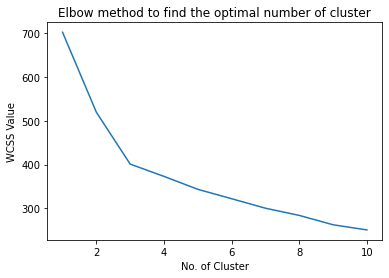

In [15]:
wcss = []
for i in range(1, 11):
    kmeans_temp = KMeans(n_clusters=i, random_state=0)
    kmeans_temp.fit(X)
    wcss.append(kmeans_temp.inertia_)
    
plt.plot(range(1, 11), wcss)
plt.title('Elbow method to find the optimal number of cluster')
plt.xlabel('No. of Cluster')
plt.ylabel('WCSS Value')
plt.show()

In [25]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
print(silhouette_score(X, kmeans.labels_, metric='euclidean'))

complete_feature_set['kmeans'] = kmeans.labels_
songDF_SJ['kmeans'] = kmeans.labels_

0.30675251206870635


In [17]:
complete_feature_set.groupby(['kmeans']).mean().iloc[:, :12]

,genre|boy,genre|chinese,genre|electropop,genre|girl,genre|group,genre|idol,genre|korean,genre|pop,genre|rap,genre|singer,genre|songwriter,genre|worship
kmeans,,,,,,,,,,,,
0,0.446430,0.002011,0.000000,0.002743,0.446317,0.002105,0.000000,0.672011,0.002897,0.000000,0.000000,0.000000
1,0.005121,0.000000,0.000000,0.000000,0.005113,0.000000,0.683593,0.635862,0.000000,0.000000,0.000000,0.009844
2,0.392292,0.008014,0.004401,0.000000,0.391690,0.004247,0.050930,0.633636,0.000000,0.004071,0.004071,0.000000


In [18]:
complete_feature_set.groupby(['kmeans']).mean().iloc[:, 12:]

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,popularity
kmeans,,,,,,,,,,,,
0,0.626033,0.767025,0.375367,0.743942,1.000000,0.054961,0.198947,0.022785,0.338670,0.568069,0.409541,0.330468
1,0.476945,0.428708,0.403559,0.585892,0.925926,0.015459,0.525470,0.144600,0.163639,0.273891,0.392089,0.355045
2,0.671747,0.798510,0.609467,0.740819,0.000000,0.086104,0.154200,0.037163,0.327737,0.609051,0.395194,0.347480


In [19]:
complete_feature_set.kmeans.value_counts()

0    341
1    189
2    169
Name: kmeans, dtype: int64

In [23]:
type0 = complete_feature_set[complete_feature_set['kmeans'] == 0]
type1 = complete_feature_set[complete_feature_set['kmeans'] == 1]
type2 = complete_feature_set[complete_feature_set['kmeans'] == 2]

My playlist can be categorized into three main types. Type 0 is an energetic and hyper song list. Type 1 is a ballad song list that the songs are relatively quiet and calming. Type 2 is a dance pop song list with catchy melody.

### Other's Song List

In [34]:
playlist_link = playlist_link2
playlist_URI = playlist_link.split("/")[-1].split("?")[0]

In [35]:
data = get_playlist_tracks(user_name, playlist_URI)

In [36]:
track_uris = [x["track"]["uri"] for x in data]

In [37]:
track_uri = []
track_name = []
artist_uri = []
artist_info = []
artist_name = []
artist_pop = []
artist_genres = []
album = []
track_pop = []
audio_feature = []

for track in data:

    #URI
    track_uri_ = track["track"]["uri"]
    track_uri.append(track["track"]["uri"])
    
    #Track name
    track_name.append(track["track"]["name"])

    #Main Artist
    artist_uri = track["track"]["artists"][0]["uri"]
    artist_info = sp.artist(artist_uri)
    
    #Name, popularity, genre
    artist_name.append(track["track"]["artists"][0]["name"])
    artist_pop.append(artist_info["popularity"])
    artist_genres.append(artist_info["genres"])
    
    #Album
    album.append(track["track"]["album"]["name"])
    
    #Popularity of the track
    track_pop.append(track["track"]["popularity"])
    
    audio_feature.append(sp.audio_features(track_uri_)[0])    

In [38]:
df = pd.DataFrame(audio_feature)
df['song'] = track_name
df['album'] = album
df['popularity'] = track_pop
df['genre'] = artist_genres
df['artist'] = artist_name
df.head(1)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,uri,track_href,analysis_url,duration_ms,time_signature,song,album,popularity,genre,artist
0,0.671,0.826,10,-4.358,1,0.0586,0.0809,0.0,0.359,0.438,...,spotify:track:0B6Ts6gTea9SKGslwpbIG7,https://api.spotify.com/v1/tracks/0B6Ts6gTea9S...,https://api.spotify.com/v1/audio-analysis/0B6T...,251541,4,BE WELL,THE 20TH ANNIVERSARY,0,"[classic k-pop, k-pop, k-pop boy group]",SECHSKIES


In [39]:
songDF = drop_duplicates(df)
print("Are all songs unique: ",len(pd.unique(songDF.artists_song))==len(songDF))
print("Length of songDF dataframe:", len(songDF))

Are all songs unique:  True
Length of songDF dataframe: 316


In [40]:
songDF = select_cols(songDF)

In [41]:
float_cols = songDF.dtypes[(songDF.dtypes == 'int64') | (songDF.dtypes == 'float64')].index.values
complete_feature_set2 = create_feature_set(songDF, float_cols=float_cols)
complete_feature_set2.head(1)

,genre|anime,genre|boy,genre|classic,genre|dance,genre|electropop,genre|girl,genre|group,genre|hip,genre|hop,genre|indie,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,popularity,id
0,0.0,0.388047,0.754631,0.0,0.0,0.0,0.258675,0.0,0.0,0.0,...,0.625076,1.0,0.084529,0.086304,0.0,0.370938,0.402057,0.033963,0.0,0B6Ts6gTea9SKGslwpbIG7


In [42]:
X_test = complete_feature_set2.drop(columns=['id'])

In [43]:
col_not_in_SJ = []
missing_col = []
for col in X_test.columns:
    if not col in X.columns:
        col_not_in_SJ.append(col)
X_test = X_test.drop(columns=col_not_in_SJ)

for col in X.columns:
    if not col in X_test.columns:
        missing_col.append(col)
        
for col in missing_col:
    X_test[col] = 0

In [44]:
songDF['kmeans'] = kmeans.predict(X_test)
complete_feature_set2['kmeans'] = kmeans.predict(X_test)

In [45]:
complete_feature_set2['kmeans'].value_counts()

1    224
2     90
0      2
Name: kmeans, dtype: int64

As the majority of the songs are in type 1 cluster, we will classify this person's music preference as type 1.

### Song Recommendation

In [46]:
col_not_in_type3 = []
missing_col3 = []
for col in complete_feature_set2.columns:
    if not col in type3.columns:
        col_not_in_type3.append(col)
complete_feature_set2 = complete_feature_set2.drop(columns=col_not_in_type3)

for col in type3.columns:
    if not col in complete_feature_set2.columns:
        missing_col3.append(col)
        
for col in missing_col3:
    complete_feature_set2[col] = 0

In [47]:
complete_feature_set_nonplaylist = type1
complete_feature_set2 = complete_feature_set2[type1.columns]
complete_feature_set_playlist_vector = complete_feature_set2.drop(columns=['id']).sum(axis=0)

In [48]:
def generate_playlist_recos(df, features, nonplaylist_features):

    non_playlist_df = df[df['id'].isin(nonplaylist_features['id'].values)]
    non_playlist_df['sim'] = cosine_similarity(nonplaylist_features.drop('id', axis = 1).values, features.values.reshape(1, -1))[:,0]
    non_playlist_df_top_40 = non_playlist_df.sort_values('sim',ascending = False).head(40)
    
    return non_playlist_df_top_40


In [49]:
recommend = generate_playlist_recos(songDF_SJ, 
                                    complete_feature_set_playlist_vector, 
                                    complete_feature_set_nonplaylist)
recommend.head(10)

,artist,id,song,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genre,popularity,kmeans,sim
753,YESUNG,21uYcyeyfPIB0VNsbCKMgO,Pink Magic,0.766,0.680,6,-4.059,1,0.0344,0.2770,0.000001,0.1280,0.736,118.024,"[k-pop, korean pop]",39,1,0.917826
681,KYUHYUN,7e3TAg5OgWDCt3kgpQbcOq,Together,0.745,0.748,7,-4.001,1,0.0285,0.2000,0.000000,0.1200,0.754,120.078,"[k-pop, korean pop]",24,1,0.916727
770,YESUNG,3s0nlyUHJQLLnoQiHr5L2n,Fly 번지점프,0.568,0.782,4,-4.214,1,0.0458,0.2690,0.000000,0.1270,0.626,94.040,"[k-pop, korean pop]",26,1,0.911761
818,RYEOWOOK,1bnWDLEWqWQARD2REeKRmk,Foxy Girl,0.726,0.883,8,-3.288,1,0.0817,0.0777,0.000000,0.0867,0.771,105.002,"[k-pop, korean pop]",21,1,0.911609
737,YESUNG,6K2YtSpArffmc600uc3IvD,Let Me Kiss,0.711,0.731,3,-5.476,1,0.0281,0.3970,0.000000,0.3590,0.557,114.987,"[k-pop, korean pop]",20,1,0.907550
793,RYEOWOOK,2H2lZut9aNfkhYZLGTxVrC,Something Good,0.608,0.865,5,-3.055,1,0.0547,0.0834,0.000000,0.0723,0.631,91.028,"[k-pop, korean pop]",20,1,0.906841
794,RYEOWOOK,42bOZg5QT1z2wlO1YbKugN,Sugar,0.725,0.713,7,-5.177,1,0.0532,0.0410,0.000000,0.0575,0.622,106.996,"[k-pop, korean pop]",19,1,0.905478
651,KYUHYUN,30BVbdFxthL4FclYG8Tl6t,めぐり逢う未来で,0.496,0.842,7,-5.043,1,0.0342,0.1220,0.000000,0.3970,0.485,138.999,"[k-pop, korean pop]",19,1,0.905211
809,RYEOWOOK,5YFz7aEb85Q4ZAR9hYUNMa,桜の花が咲く頃,0.501,0.932,4,-3.561,1,0.0593,0.2460,0.000000,0.3520,0.620,167.990,"[k-pop, korean pop]",18,1,0.905044
657,KYUHYUN,4x7QfmxIY5iDk3RaHMyBQa,마음세탁소 When with me,0.647,0.627,7,-4.953,1,0.0303,0.5470,0.000000,0.1070,0.464,114.961,"[k-pop, korean pop]",27,1,0.902077


In [50]:
songDF[["artist","song"]][:20]

,artist,song
0,SECHSKIES,BE WELL
1,f(x),Airplane
2,2NE1,I Am the Best (내가 제일 잘 나가)
3,2NE1,Ugly
4,2NE1,Lonely
5,f(x),Electric Shock
6,f(x),Beautiful Stranger (by f(Amber+Luna+Krystal))
7,10cm,Pet
8,TVXQ!,주문 Mirotic - Live
9,f(x),4 Walls


As shown above, this person has a song list that contains a lot of ballad genre music. Thus, using type 1 song list recommend songs to this person will best fit her preference.